In [26]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score as auc, accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import numpy as np

from func import rm_high_corr_feat

# Model 1 - Агрегированные данные по командам

In [27]:
df = pd.read_csv('../prepare_data/data/df_res.csv')

In [28]:
df = df[df['gameweek_compSeason_label'] > 2019]

In [29]:
df['teams_team_1_name'].unique()

array(['Wolverhampton Wanderers', 'Tottenham Hotspur',
       'Nottingham Forest', 'Manchester City', 'Liverpool', 'Fulham',
       'Crystal Palace', 'Aston Villa', 'Newcastle United',
       'Manchester United', 'Everton', 'Chelsea', 'Burnley', 'Brentford',
       'Bournemouth', 'Arsenal', 'West Ham United', 'Sheffield United',
       'Southampton', 'Leicester City', 'Leeds United', 'Norwich City',
       'Watford', 'West Bromwich Albion'], dtype=object)

In [30]:
df

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,team_1_hue,_accurate_back_zone_pass_team_1,_accurate_chipped_pass_team_1,_accurate_corners_intobox_team_1,_accurate_cross_team_1,...,_total_through_ball_lag_team2,_total_throws_lag_team2,_total_yel_card_lag_team2,_touches_lag_team2,_touches_in_opp_box_lag_team2,_unsuccessful_touch_lag_team2,_wins_lag_team2,_won_contest_lag_team2,_won_corners_lag_team2,_won_tackle_lag_team2
0,20,2023,Wolverhampton Wanderers,Everton,Molineux Stadium,1,7582.25,832.750000,43.750000,160.250000,...,39.0,707.0,79.0,21481.0,786.0,605.0,8.0,303.0,175.0,424.0
1,20,2023,Tottenham Hotspur,Bournemouth,Tottenham Hotspur Stadium,1,8308.50,685.500000,41.750000,140.500000,...,49.0,706.0,69.0,21201.0,743.0,588.0,11.0,320.0,144.0,371.0
2,20,2023,Nottingham Forest,Manchester United,The City Ground,1,5016.00,601.000000,29.000000,104.000000,...,105.0,715.0,78.0,25964.0,1093.0,497.0,23.0,319.0,195.0,400.0
3,20,2023,Manchester City,Sheffield United,Etihad Stadium,1,10041.25,918.750000,65.750000,168.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,2023,Liverpool,Newcastle United,Anfield,1,9401.25,967.750000,64.250000,195.500000,...,88.0,728.0,62.0,23410.0,1223.0,576.0,19.0,349.0,270.0,360.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,1,10041.25,918.750000,65.750000,168.500000,...,17.0,797.0,68.0,21368.0,726.0,546.0,9.0,352.0,201.0,291.0
1182,1,2020,Liverpool,Leeds United,Anfield,1,9401.25,967.750000,64.250000,195.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,0,7339.00,670.000000,53.000000,181.500000,...,67.0,756.0,86.0,25916.0,876.0,547.0,14.0,411.0,232.0,336.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,1,6535.25,618.500000,46.000000,141.000000,...,27.0,950.0,53.0,23611.0,879.0,654.0,15.0,423.0,210.0,416.0


In [31]:
n = 100

train = df.iloc[n:, :]
val = df.iloc[:n, :]

y_train = train['team_1_hue']
x_train = train.drop('team_1_hue', axis=1)

y_val = val['team_1_hue']
x_val = val.drop('team_1_hue', axis=1)

In [32]:
cat = ['gameweek_gameweek',	'gameweek_compSeason_label', 'teams_team_1_name', 'teams_team_2_name', 'ground_name']

In [33]:
model_1 = CatBoostClassifier()


In [34]:
model_1.fit(x_train, y_train, cat_features=cat, verbose=False)


In [35]:
pred = model_1.predict(x_val)
pred_proba = model_1.predict_proba(x_val)
y_val = y_val.to_numpy().reshape(-1, 1)

In [36]:
pred = np.concatenate((y_val, pred, pred_proba), axis=1)
df_pred = pd.DataFrame(pred, columns=['true', 'pred', '0_prob', '1_prob', '2_prob'])

In [37]:
df_pred['error'] = np.where(df_pred['true']==df_pred['pred'], 0, 1)

df_pred.head()

,true,pred,0_prob,1_prob,2_prob,error
0,1.0,1.0,0.123565,0.616682,0.259753,0
1,1.0,1.0,0.044057,0.928870,0.027074,0
2,1.0,0.0,0.497876,0.254441,0.247683,1
3,1.0,1.0,0.014365,0.967856,0.017778,0
4,1.0,1.0,0.048161,0.834329,0.117511,0


In [38]:
df_pred['error'].sum()

54

In [39]:
df_pred.shape

(100, 6)

In [40]:
accuracy_score(df_pred['true'], df_pred['pred'])

0.46

# Модели на датасетах с отбором признаков 

In [41]:
thrs = [i/100 for i in range(100, 10, -5)] # Список значений корреляций для удаления признаков

In [42]:
acc_score_val, acc_score_train = [], []
for thr in tqdm(thrs):

    
    df_temp = rm_high_corr_feat(df, thr, 6)


    train = df_temp.iloc[n:, :]
    val = df_temp.iloc[:n, :]

    y_train = train['team_1_hue']
    x_train = train.drop('team_1_hue', axis=1)

    y_val = val['team_1_hue']
    x_val = val.drop('team_1_hue', axis=1)

    model_temp = CatBoostClassifier(iterations=2000, learning_rate=0.0005, loss_function='MultiClass')
    model_temp.fit(x_train, y_train, cat_features=cat, verbose=False)

    pred_temp = model_temp.predict(x_val)
    pred_temp_train = model_temp.predict(x_train)

    score_temp = accuracy_score(pred_temp, y_val)
    score_temp_train = accuracy_score(pred_temp_train, y_train)

    #print(f'thr: {thr}\naccuracy: {np.round(score_temp, 3)}\nпризнаков: {df_temp.shape[1]}\n')

    acc_score_val.append(score_temp)
    acc_score_train.append(score_temp_train)


100%|██████████| 18/18 [04:31<00:00, 15.08s/it]


<Axes: xlabel='Корреляция', ylabel='Accuracy'>

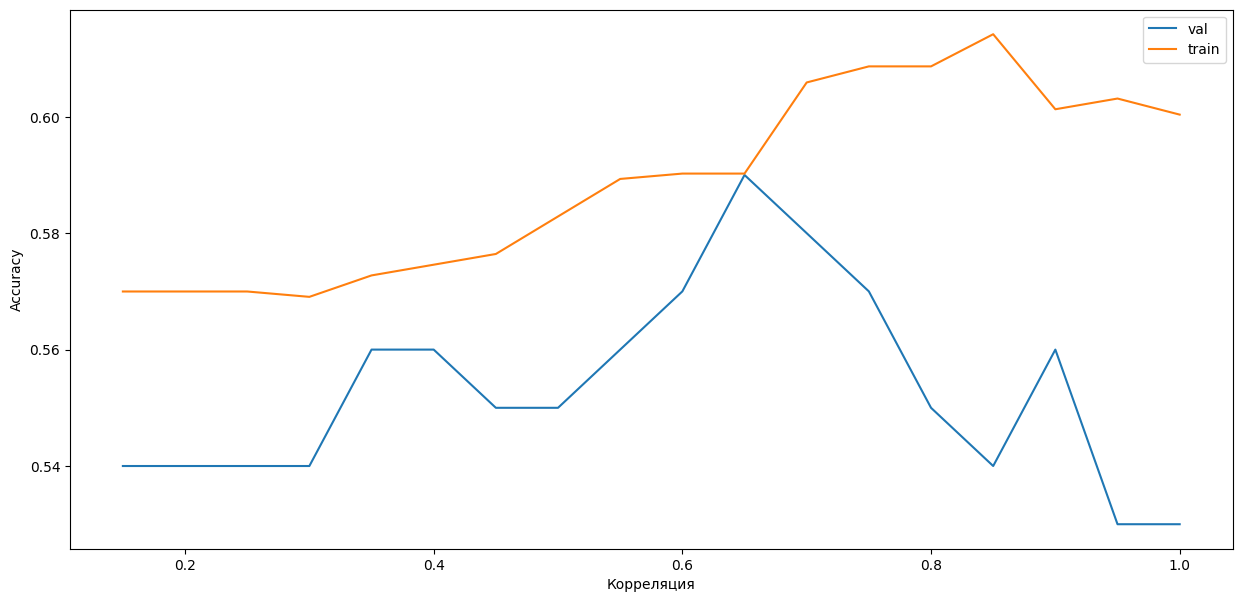

In [43]:
plt.figure(figsize=(15, 7))
plt.xlabel('Корреляция')
plt.ylabel('Accuracy')

sns.lineplot(x=thrs, y=acc_score_val, label='val')
sns.lineplot(x=thrs, y=acc_score_train, label='train')

Возьмем датасет с отобранными признаки, где корреляция не выше 0.4 между признаками

In [47]:
df_temp = rm_high_corr_feat(df, 0.65, 6)

train = df_temp.iloc[n:, :]
val = df_temp.iloc[:n, :]

y_train = train['team_1_hue']
x_train = train.drop('team_1_hue', axis=1)

y_val = val['team_1_hue']
x_val = val.drop('team_1_hue', axis=1)

In [48]:
df_temp

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,team_1_hue,_accurate_back_zone_pass_team_1,_accurate_corners_intobox_team_1,_accurate_freekick_cross_team_1,_accurate_goal_kicks_team_1,...,_overrun_lag_team2,_own_goal_accrued_lag_team2,_penalty_conceded_lag_team2,_pts_dropped_winning_pos_lag_team2,_pts_gained_losing_pos_lag_team2,_second_yellow_lag_team2,_shield_ball_oop_lag_team2,_six_yard_block_lag_team2,_subs_goals_lag_team2,_total_red_card_lag_team2
0,20,2023,Wolverhampton Wanderers,Everton,Molineux Stadium,1,7582.25,43.750000,16.500000,182.000000,...,41.0,2.000000,6.0,17.0,9.0,1.000000,24.0,14.0,2.000000,2.0
1,20,2023,Tottenham Hotspur,Bournemouth,Tottenham Hotspur Stadium,1,8308.50,41.750000,7.750000,217.000000,...,55.0,2.275362,7.0,15.0,12.0,1.581395,26.0,16.0,3.000000,2.5
2,20,2023,Nottingham Forest,Manchester United,The City Ground,1,5016.00,29.000000,15.000000,197.000000,...,29.0,2.000000,3.0,7.0,11.0,1.581395,34.0,14.0,7.000000,2.0
3,20,2023,Manchester City,Sheffield United,Etihad Stadium,1,10041.25,65.750000,11.500000,136.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20,2023,Liverpool,Newcastle United,Anfield,1,9401.25,64.250000,16.000000,177.250000,...,51.0,5.000000,5.0,11.0,14.0,1.581395,21.0,27.0,7.000000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,1,10041.25,65.750000,11.500000,136.250000,...,70.0,1.000000,6.0,23.0,9.0,1.000000,22.0,21.0,4.285714,1.0
1182,1,2020,Liverpool,Leeds United,Anfield,1,9401.25,64.250000,16.000000,177.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,0,7339.00,53.000000,15.500000,199.000000,...,65.0,2.275362,8.0,21.0,18.0,1.000000,26.0,18.0,4.285714,5.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,1,6535.25,46.000000,21.500000,168.500000,...,80.0,2.275362,4.0,17.0,13.0,1.000000,25.0,24.0,4.285714,4.0


In [49]:
df_temp.to_csv('../prepare_data/data/df_temp_65.csv', index=False)

In [50]:
grid = {'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 12]}

In [51]:
score = 0
train_list, val_list = [], []
for depth in grid['depth']:
    for l2 in grid['l2_leaf_reg']:
        

        model_temp = CatBoostClassifier(iterations=2000, learning_rate=0.0005, loss_function='MultiClass', depth=depth, l2_leaf_reg=l2)
        model_temp.fit(x_train, y_train, cat_features=cat, verbose=False)

        pred_temp = model_temp.predict(x_val)
        pred_temp_train = model_temp.predict(x_train)

        score_temp = accuracy_score(pred_temp, y_val)
        score_temp_train = accuracy_score(pred_temp_train, y_train)

        train_list.append(score_temp_train) 
        val_list.append(score_temp)

        if score_temp > score:            
            score = score_temp
            print(f'accuracy: {np.round(score_temp, 3)}\ndepth: {depth}\nl2_leaf_reg: {l2}\n')

        #print(f'accuracy: {np.round(score_temp, 3)}\ndepth: {depth}\nl2_leaf_reg: {l2}\n')


accuracy: 0.59
depth: 2
l2_leaf_reg: 1

accuracy: 0.6
depth: 2
l2_leaf_reg: 3



<Axes: xlabel='x', ylabel='Accuracy'>

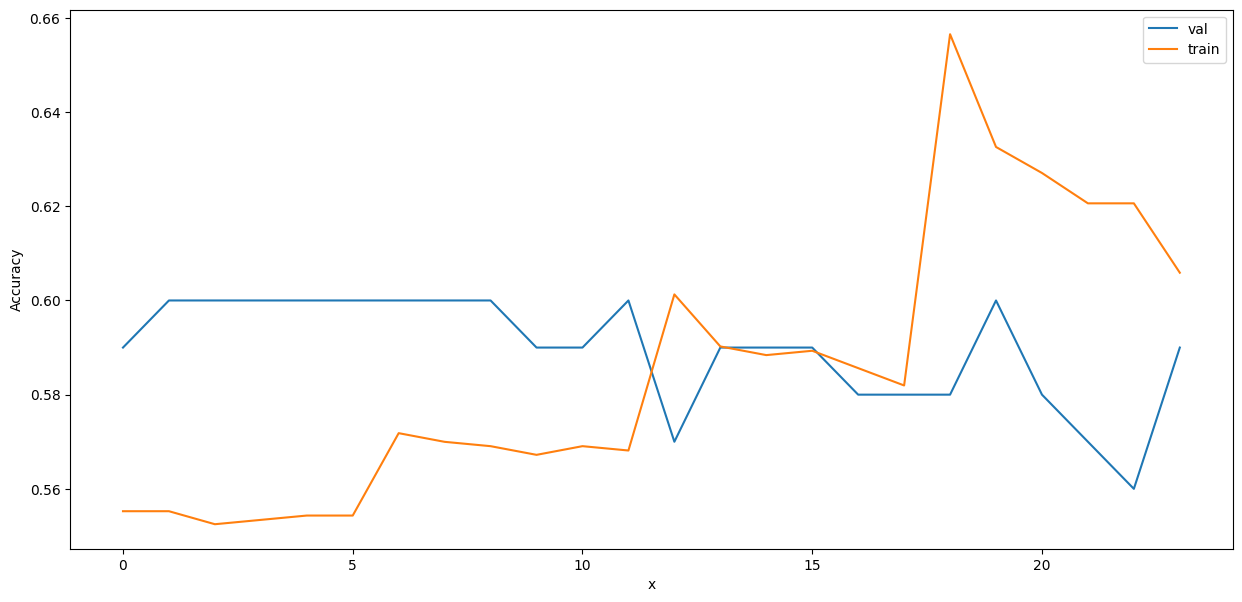

In [52]:
plt.figure(figsize=(15, 7))
plt.xlabel('x')
plt.ylabel('Accuracy')

sns.lineplot(x=[i for i in range(len(val_list))], y=val_list, label='val')
sns.lineplot(x=[i for i in range(len(val_list))], y=train_list, label='train')

## Data pickl

In [55]:
name_cols = 'pickle/name_cols.pickle'

col_pkl = list(df_temp.columns)
col_pkl.remove('team_1_hue')

with open(name_cols, 'wb') as file:
    pickle.dump(col_pkl, file)


In [54]:
model = CatBoostClassifier(iterations=2000, learning_rate=0.0005, loss_function='MultiClass', depth=4, l2_leaf_reg=6)
model.fit(x_train, y_train, cat_features=cat, verbose=False)

with open('pickle/catboost.pickle', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
x_train

,gameweek_gameweek,gameweek_compSeason_label,teams_team_1_name,teams_team_2_name,ground_name,_accurate_back_zone_pass_team_1,_accurate_freekick_cross_team_1,_accurate_goal_kicks_team_1,_accurate_keeper_sweeper_team_1,_accurate_keeper_throws_team_1,...,_goal_fastbreak_lag_team2,_hand_ball_lag_team2,_last_man_tackle_lag_team2,_overrun_lag_team2,_own_goal_accrued_lag_team2,_penalty_conceded_lag_team2,_pts_gained_losing_pos_lag_team2,_second_yellow_lag_team2,_shield_ball_oop_lag_team2,_total_red_card_lag_team2
100,8,2023,Crystal Palace,Nottingham Forest,Selhurst Park,6535.25,21.500000,168.500000,14.00,184.75,...,3.0,19.0,5.0,43.0,2.000000,9.0,9.0,1.581395,21.0,2.5
101,8,2023,Burnley,Chelsea,Turf Moor,4121.00,19.666667,143.333333,25.00,155.00,...,1.0,16.0,6.0,48.0,1.000000,1.0,8.0,2.000000,29.0,3.0
102,8,2023,Arsenal,Manchester City,Emirates Stadium,8158.50,10.750000,152.000000,16.25,194.50,...,7.0,12.0,2.0,26.0,2.000000,3.0,10.0,1.581395,15.0,1.0
103,7,2023,Wolverhampton Wanderers,Manchester City,Molineux Stadium,7582.25,16.500000,182.000000,13.00,170.75,...,7.0,12.0,2.0,26.0,2.000000,3.0,10.0,1.581395,15.0,1.0
104,7,2023,West Ham United,Sheffield United,London Stadium,5829.50,13.750000,185.250000,7.50,155.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,19,2020,Manchester City,Aston Villa,Etihad Stadium,10041.25,11.500000,136.250000,17.00,172.25,...,1.0,19.0,3.0,70.0,1.000000,6.0,9.0,1.000000,22.0,1.0
1182,1,2020,Liverpool,Leeds United,Anfield,9401.25,16.000000,177.250000,31.00,205.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1183,1,2020,Fulham,Arsenal,Craven Cottage,7339.00,15.500000,199.000000,15.00,184.50,...,2.0,12.0,1.0,65.0,2.275362,8.0,18.0,1.000000,26.0,5.0
1184,1,2020,Crystal Palace,Southampton,Selhurst Park,6535.25,21.500000,168.500000,14.00,184.75,...,2.0,21.0,4.0,80.0,2.275362,4.0,13.0,1.000000,25.0,4.0
